# Projet Datascientest
## Détection d'anomalies dans des pièces industrielles

L’objectif de ce projet est de développer un modèle capable de détecter une anomalie sur une pièce industrielle à l’aide d’une image. Pour cela, il est possible d’utiliser un réseau de neurones convolutif (CNN) ou toute autre architecture adaptée à ce type de problématique. Plusieurs approches sont envisageables pour ce projet, avec un apprentissage supervisé ou non supervisé. Un premier objectif est d’effectuer une classification binaire sur les images des jeux de données, pour isoler les images présentant une anomalie. Un second objectif est d’identifier l’anomalie détectée, transformant ainsi le problème en classification multi-classes. Chaque pièce est associée à une série d’anomalies qui lui sont propres.

### Objectifs
1. Detection d'anomalies dans les images (classification binaire)
2. Classification (multi-class) d'anomalie détectée
3. Création d'un application Streamlit avec le modèle final

## Datasets

### 1. MVTec
**url:** https://www.mvtec.com/company/research/datasets/mvtec-ad

**Description:** Dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over 5000 high-resolution images divided into fifteen different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects.

**Dataset size:** over 5000 high-resolution images

**Definition of defects for dataset:** Pixel-precise annotations of all anomalies are provided.

**Categories of object:**
- Bottle
- Cable
- Capsule
- Carpet
- Grid
- Hazelnut
- Leather
- Metal Nut
- Pill
- Screw
- Tile
- Toothbrush
- Transistor
- Wood
- Zipper

### 2. RAD
**url:** https://github.com/hustCYQ/RAD-dataset

**Description:** Robust Anomaly Detection (RAD) dataset with free views, uneven illuminations, and blurry collections to systematically evaluate the robustness of current anomaly detection methods.

**Definition of defects for dataset:** Normal scenarios depict a work platform with multiple metal holes, whereas the abnormal scenarios feature the work platform with foreign objects. To establish a comprehensive benchmark for anomaly detection robustness, we introduce different types of foreign objects onto the work platform, including bolts, cable ties, sponges, and tapes. Subsequently, the images are captured under various imaging noises, encompassing random viewpoints, illuminations, and imaging distances to replicate practical noise scenarios.

**Dataset size:** 286 normal samples, of which 213 are used for training, and the remaining 73 for testing. Additionally, 327, 293, 281, and 323 abnormal samples across the four categories are used for testing.

**Categories:**
- Bolt
- Ribbon
- Sponge
- Tape


> **Note:** Images presentant des défauts sont présent seulement dans les sets de 'test' pour les deux datasets

In [56]:
# Libraries import

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path


In [74]:
# Functions

def display_img(img_path:str, img:str = 'random', print_info:bool = True) -> str:
    img_list = os.listdir(img_path)
    if img == 'random':
        img_file = random.choice(img_list)
    else:
        if img in img_list:
            img_file = img
        else:
            raise IOError(f"File {img} not found in directory {img_path}")

    img_array = cv2.imread(os.path.join(img_path, img_file), cv2.IMREAD_COLOR)
    if print_info:
        print(f'Image randomly chosen: {img_file}')
        print(f"Size of image: {img_array.shape}")
    plt.imshow(img_array)
    plt.show()
    return img_file



def count_img_categories(filepath: str, filetype: str) -> dict:

    p = Path(filepath)
    files_dict = {}
    for subdir in p.iterdir():
        if subdir.is_dir():
            files = subdir.rglob(f"*.{filetype}")
            filecount = 0
            for f in files:
                filecount += 1
            files_dict[subdir.name] = filecount

    return files_dict
    

## MVTec DataViz' Overview


Displaying random 'good'/ non-defective image from transistor category:
Image randomly chosen: 191.png
Size of image: (1024, 1024, 3)


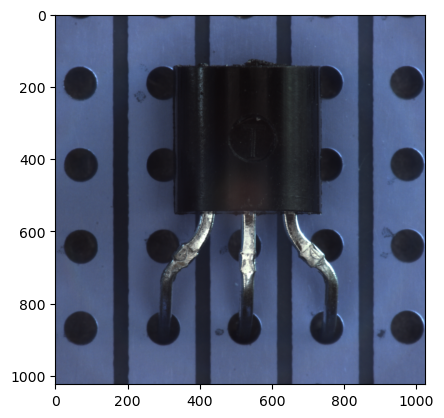

Displaying random defective (bent lead) image from transistor category:
Image randomly chosen: 000.png
Size of image: (1024, 1024, 3)


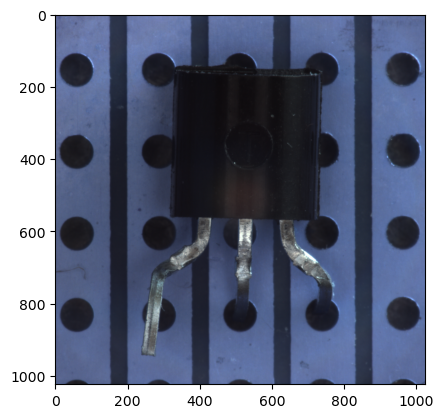

000.png
Displaying corresponding ground truth of bent lead defective image:
Image randomly chosen: 000_mask.png
Size of image: (1024, 1024, 3)


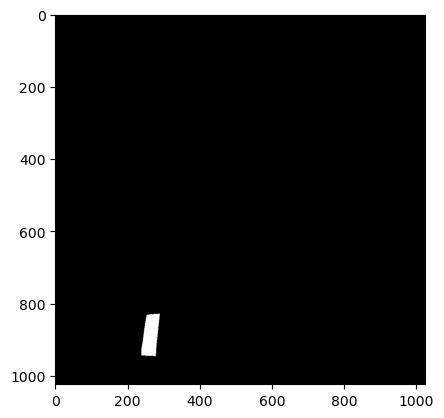

'000_mask.png'

In [106]:
print("Displaying random 'good'/ non-defective image from transistor category:")
img_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/transistor/train/good'
display_img(img_path)

print("Displaying random defective (bent lead) image from transistor category:")
img_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/transistor/test/bent_lead'
bent_lead_img = display_img(img_path)
print(bent_lead_img)

print("Displaying corresponding ground truth of bent lead defective image:")
img_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/transistor/ground_truth/bent_lead'
mask = x = bent_lead_img.replace(".png", "_mask.png")
display_img(img_path, img=mask)


{'bent_lead': 10, 'cut_lead': 10, 'damaged_case': 10, 'good': 60, 'misplaced': 10, 'train': 213}


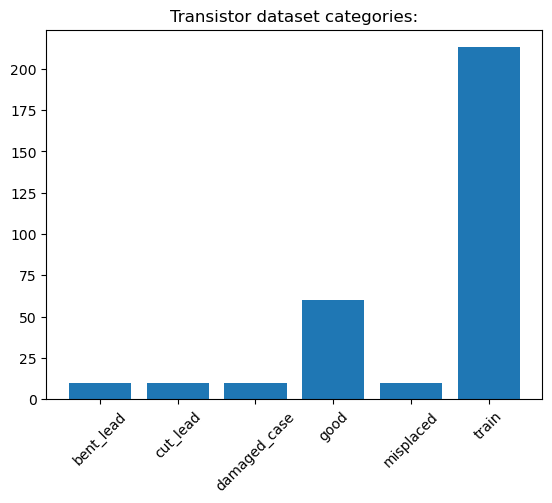

In [91]:
transistor_test_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/transistor/test'
imgs_cats_dict = count_img_categories(transistor_test_path, 'png')

transistor_train_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/transistor/train/good'
training_size = len([name for name in os.listdir(transistor_train_path) if os.path.isfile(os.path.join(transistor_train_path, name))])
imgs_cats_dict['train'] = training_size
print(imgs_cats_dict)

plt.bar(range(len(imgs_cats_dict)), list(imgs_cats_dict.values()), align='center')
plt.xticks(range(len(imgs_cats_dict)), list(imgs_cats_dict.keys()), rotation=45)
plt.title('Transistor dataset categories:')
plt.show()


{'good': 41, 'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23, 'train': 320}


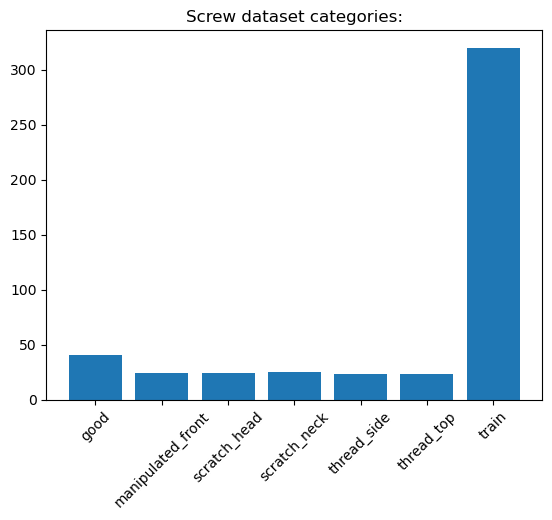

In [92]:
transistor_test_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/screw/test'
imgs_cats_dict = count_img_categories(transistor_test_path, 'png')

transistor_train_path = '/home/suzy/datascientest/anomalie_proj/datasets/MVTec/screw/train/good'
training_size = len([name for name in os.listdir(transistor_train_path) if os.path.isfile(os.path.join(transistor_train_path, name))])
imgs_cats_dict['train'] = training_size
print(imgs_cats_dict)

plt.bar(range(len(imgs_cats_dict)), list(imgs_cats_dict.values()), align='center')
plt.xticks(range(len(imgs_cats_dict)), list(imgs_cats_dict.keys()), rotation=45)
plt.title('Screw dataset categories:')
plt.show()

## RAD DataViz' Overview